# Fashion MNIST FCNN Hyperparameter Tuning

**Problem Statement & Objective**:

While the Fashion MNIST dataset is a standard benchmark in computer vision, the primary objective of this project is to conduct a systematic, empirical investigation into the dynamics of a Fully Connected Neural Network (FCNN).

Rather than simply maximizing accuracy, this project aims to build a reproducible, modular experimentation pipeline to analyze how variations in network capacity (hidden nodes), non-linearities (activation functions), and loss topologies impact model convergence, generalization capability, and overfitting. By establishing a baseline and isolating individual hyperparameters, this study seeks to derive data-driven insights into the fundamental trade-offs in neural network architecture design.


**Dataset Description:**

We will use the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, which is designed to replace MNIST as the new minimal dataset to test vision tasks.

It is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Thus, it is almost exactly like the MNIST dataset for digit recognition, but the classification problem is generally harder.


Here are some example images:
![Fashion MNIST](https://storage.googleapis.com/tfds-data/visualization/fig/fashion_mnist-3.0.1.png)

# Methodology & Engineering Pipeline
This project follows a structured machine learning lifecycle, prioritizing modular code design and scientific rigor (e.g. deterministic seeding and session clearing) to ensure fair comparisons across experiments.

**Phase 1: Data Ingestion & Preprocessing:**

- Import the Fashion MNIST dataset and normalize pixel values to a [0, 1] scale to ensure stable gradient descent.

- Apply stratified splitting to partition the training data into robust training and validation sets, preserving class distribution.

- Implement One-Hot Encoding on target labels to accommodate diverse loss function evaluations.

**Phase 2: Architecture Modularization:**

- Develop a parameterized wrapper function (build_model) to dynamically generate and compile a 1-hidden-layer FCNN.

- Build reusable training and evaluation helper functions to reduce code redundancy and prevent data leakage during the experimentation loops.

**Phase 3: Hyperparameter Optimization:**

- **Network Capacity:** Evaluate validation performance on 64, 128, and 256 hidden nodes.

- **Activation Functions:** Compare ReLU, Sigmoid, and Tanh to analyze gradient propagation.

- **Loss Functions:** Investigate Categorical Crossentropy and Mean Squared Error.

**Phase 4: Evaluation & Diagnostics:**

- Visualize learning curves (Loss/Accuracy vs. Epochs) to diagnose overfitting and convergence stability.

- Generate confusion matrices with zeroed diagonals to highlight high-frequency misclassifications and inter-class similarities.



In [1]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
sns.set(font_scale=1.5)

In [2]:
# Import dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
# Dictionary maps the y_train/y_test labels into words
label_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
}
labels_train = [label_dict[u] for u in y_train]
labels_test = [label_dict[u] for u in y_test]

Text(0.5, 1.0, 'Label = Ankle boot')

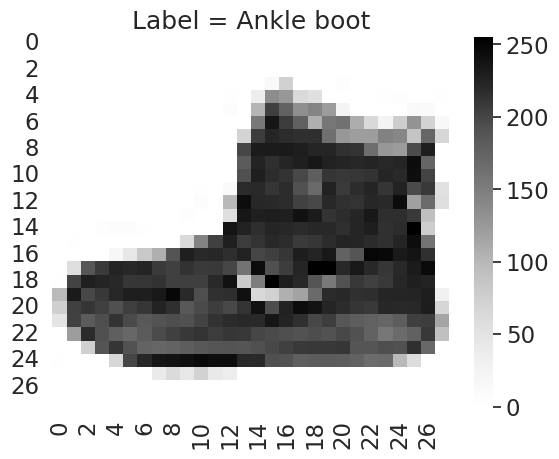

In [4]:
ax = sns.heatmap(x_train[0], cmap='Greys')
ax.set_title(f'Label = {labels_train[0]}')

In [5]:
print(x_train.shape)

(60000, 28, 28)


In [6]:
# --- Preprocessing ---

# Normalization - larger integer inputs can lead to exploding gradients and inefficiency
# Convert to float32 to ensure precision, then normalize raw pixel values from 0-255 to 0-1.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshaping - for 2D convolutional layers, Keras expects a 4D tensor (batch_size, height, width, channels)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Check new shape
print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')

# Create validation set using 20% of the training data
x_train, x_val, y_train, y_val = train_test_split(
    x_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train # Ensures balanced classes in train/val
)

# Save backup of integer labels
y_train_int = y_train
y_val_int = y_val

# Convert all label sets to One-Hot Encoding
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Check training label shape
print(f'y_train shape: {y_train.shape}')

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (48000, 10)


In [7]:
# --- Define Model Architecture ---

# Build model wrapper function for experimentation
def build_model(hidden_nodes=128, activation='relu', loss='categorical_crossentropy', dropout_rate=0.0):

  model = models.Sequential([

      # Flatten to a list of numbers to enable a feed-forward network
      layers.Flatten(),
      # Fully connected Dense layers that combine learned visual features
      layers.Dense(units=hidden_nodes, activation=activation),
      # Dropout layer blocks memorization, mitigating overfitting scenarios
      layers.Dropout(dropout_rate),
      # 10 neurons for 10 classes, softmax converts scores to probabilities
      layers.Dense(units=10, activation='softmax')
  ])

  # Verify shapes
  model.summary()

  # Compile the Model
  model.compile(
      # Adaptive Moment Estimation (adam) adjusts weights to minimize error and adapts learning rate automatically, unlike the fixed learning rate of SGD
      optimizer='adam',
      # Loss function for multi-class classification where labels are integers
      loss=loss,
      # Classes are balanced so accuracy is a safe and interpretable metric
      metrics=['accuracy']
  )

  return model

In [8]:
# --- Train the Model ---

# Train model wrapper function
def train_model(model, x_train, y_train, x_val, y_val):

  # Assign the training result to 'history' to store loss and accuracy metrics
  history = model.fit(
      x_train, y_train,
      epochs=20,
      batch_size=64,
      validation_data=(x_val, y_val),
      verbose=0
  )

  return history

In [9]:
# --- Plot Learning Curves ---

def plot_experiment_comparison(experiments, param_key, title_label):

    plt.figure(figsize=(15, 6))

    # Graph 1: Accuracy (Train vs Val)
    plt.subplot(1, 2, 1)
    for exp in experiments:
        # Extract data
        val_acc = exp['history'].history['val_accuracy']
        train_acc = exp['history'].history['accuracy']
        label_base = f"{exp[param_key]}"

        # 1. Plot Validation (Solid Line) - Primary Metric
        line = plt.plot(val_acc, linewidth=2, linestyle='-', label=f"{label_base} (Val)")[0]
        color = line.get_color()

        # 2. Plot Training (Dashed Line) - Secondary Metric
        plt.plot(train_acc, linewidth=2, linestyle='--', color=color, alpha=0.6, label=f"{label_base} (Train)")

    plt.title(f'Accuracy: {title_label} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Graph 2: Loss (Train vs Val)
    plt.subplot(1, 2, 2)
    for exp in experiments:
        # Extract data
        val_loss = exp['history'].history['val_loss']
        train_loss = exp['history'].history['loss']
        label_base = f"{exp[param_key]}"

        # 1. Plot Validation (Solid)
        line = plt.plot(val_loss, linewidth=2, linestyle='-', label=f"{label_base} (Val)")[0]
        color = line.get_color()

        # 2. Plot Training (Dashed)
        plt.plot(train_loss, linewidth=2, linestyle='--', color=color, alpha=0.6, label=f"{label_base} (Train)")

    plt.title(f'Loss: {title_label} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [16]:
# --- Validation Set Analysis ---

# Analyze validation set wrapper function
def analyze_val(model, x_val, y_val, label_dict, title='Validation Analysis'):

  # Get summary metrics on how the model performs on validation set overall
  val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
  # Accommodate analyze function for held out test set
  if "Test" in title:
    print(f"Test Loss:     {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
  else:
    print(f"Validation Loss:     {val_loss:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")

  # Check if y_val is one-hot encoded and convert back to integers for the matrix
  if y_val.ndim == 2:
    y_true = np.argmax(y_val, axis=1)
  else:
    y_true = y_val

  # Get predictions
  val_probs = model.predict(x_val, verbose=0)
  val_preds = np.argmax(val_probs, axis=1)

  # Compare ground truth labels to the model's predictions
  val_cm = confusion_matrix(y_true, val_preds)

  # Zero out diagonal to highlight errors
  np.fill_diagonal(val_cm, 0)

  # Plot Confusion Matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=label_dict.values(),
              yticklabels=label_dict.values())
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title(f'Confusion Matrix: {title}')
  plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Validation Loss:     0.3644
Validation Accuracy: 0.8814


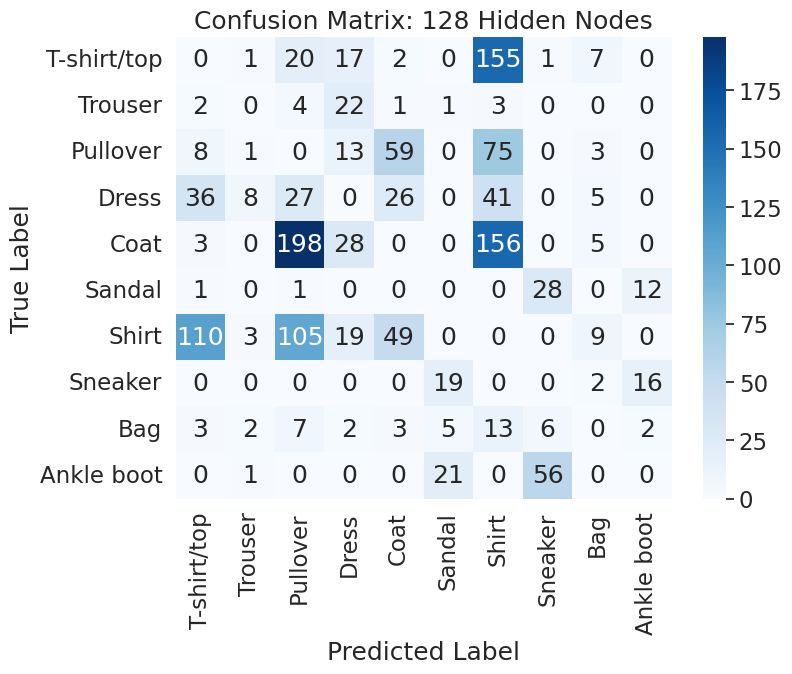

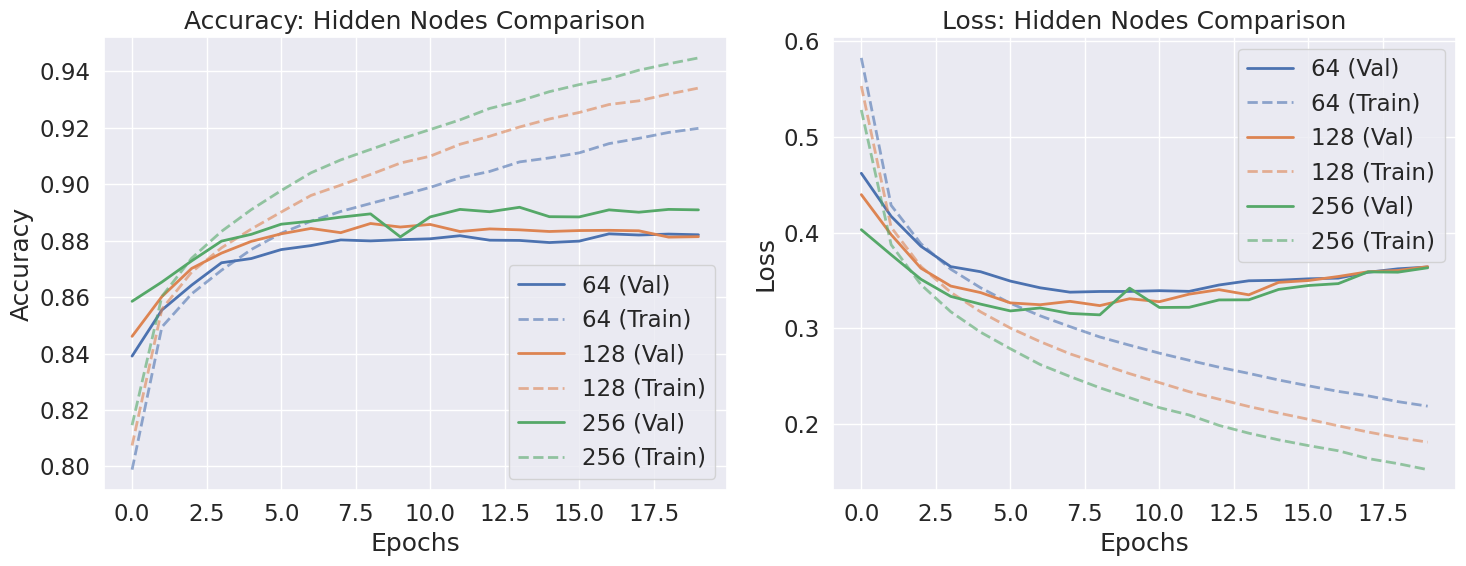

In [11]:
# --- Investigate Hidden Nodes ---

experiments_nodes = []
nodes_options = [64, 128, 256]

for nodes in nodes_options:

  # Reset memory and randomness
  tf.keras.backend.clear_session()
  tf.random.set_seed(42)
  np.random.seed(42)

  # Pass 'hidden_nodes=nodes'
  model = build_model(hidden_nodes=nodes)
  history = train_model(model, x_train, y_train, x_val, y_val)

  # Store results
  experiments_nodes.append({
      'nodes': nodes,
      'history': history,
      'model': model
  })

# Confusion Matrix for default model (128 nodes)
exp_128 = experiments_nodes[1]
analyze_val(
    model=exp_128['model'],
    x_val=x_val,
    y_val=y_val,
    label_dict=label_dict,
    title='128 Hidden Nodes'
)

# Plot comparison curves
plot_experiment_comparison(
  experiments_nodes,
  param_key='nodes',
  title_label='Hidden Nodes'
)

## Results

* With the confusion matrix diagonal values zeroed-out, we can see that the model makes the most mistakes classifying upper body garments. This is likely due to small differences in collars or buttons, which can disappear after Max Pooling layers shrink the image.

  128 Hidden Nodes (Default):
  * T-shirt/top (True) vs. Shirt (Predicted): 197 errors
  * Coat (True) vs. Shirt (Predicted): 184 errors
  * Coat (True) vs. Pullover (Predicted): 157 errors

  Experimentation with 64 and 256 Hidden Nodes:
  * Differences in validation loss and accuracy were minimal with the default model. However, 256 nodes outperform other node configurations marginally, suggesting less bias but more variance.

* The widening gap between the training and validation accuracy lines indicates overfitting of the training data.
* Validation loss flattens out at around epoch 7. The model isn't getting any better after 7 epochs.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

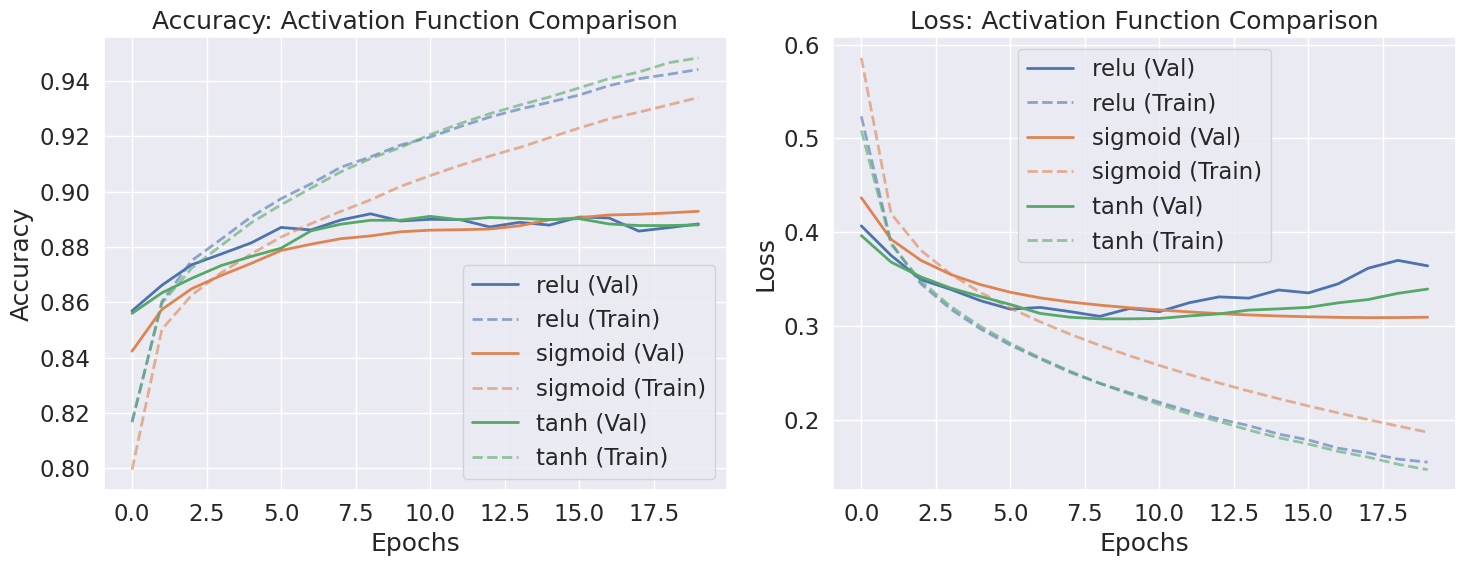

In [12]:
# --- Investigate Activation Functions ---

experiments_act = []
activation_options = ['relu', 'sigmoid', 'tanh']

for act in activation_options:

    # Reset memory and randomness
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)

    # Pass 'activation=act'
    model = build_model(hidden_nodes=256, activation=act)
    history = train_model(model, x_train, y_train, x_val, y_val)

    # Store results
    experiments_act.append({
        'act_name': act,
        'history': history,
        'model': model
    })

# Plot comparison curves
plot_experiment_comparison(
    experiments_act,
    param_key='act_name',
    title_label='Activation Function'
)

## Observations

* There is an interesting pattern in the loss curve where the Sigmoid activation function begins with the highest loss but eventually finishes with the lowest loss among the activation functions tested. This suggests that Sigmoid learns more slowly at the start, but this slower learning may help it generalize better over time.

* Overfitting is still observed across all activation functions. This suggests that the issue isn't the activation function.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

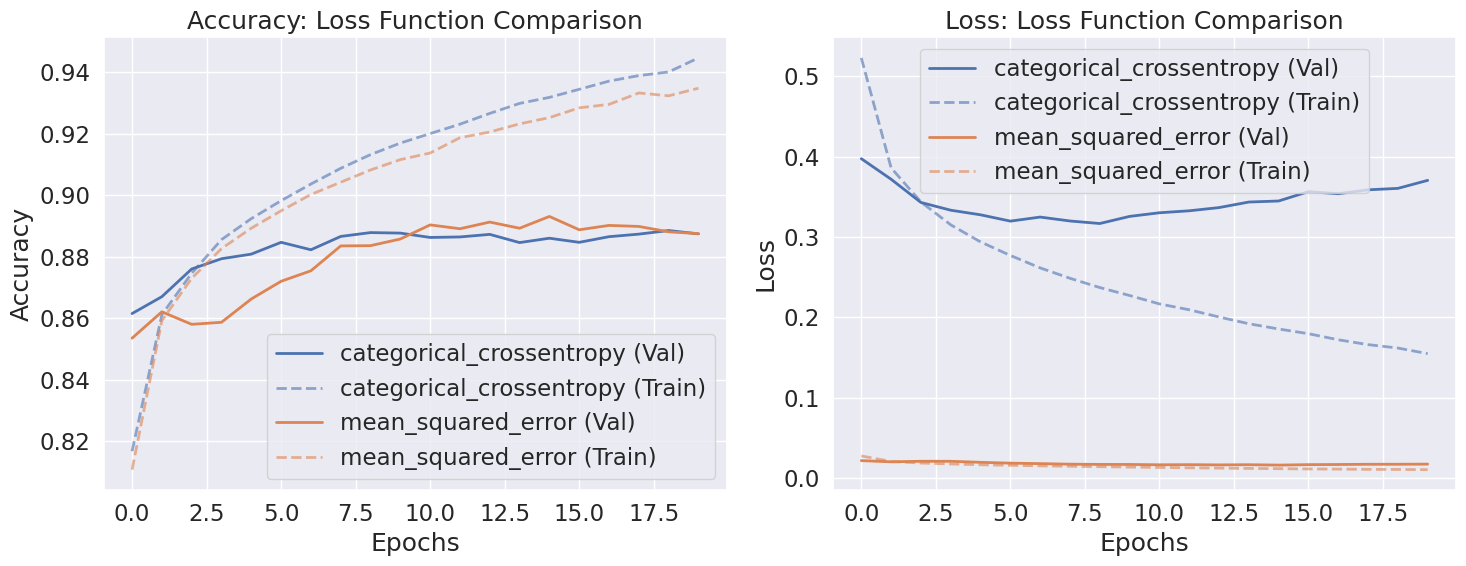

In [13]:
# --- Investigate Loss Functions ---

experiments_loss = []
loss_options = ['categorical_crossentropy', 'mean_squared_error']

for loss_name in loss_options:

    # Reset memory and randomness
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)

    # Pass 'loss=loss_name'
    model = build_model(hidden_nodes=256, loss=loss_name)
    history = train_model(model, x_train, y_train, x_val, y_val)

    # Store results
    experiments_loss.append({
        'loss_type': loss_name,
        'history': history,
        'model': model
    })

# Plot comparison curves
plot_experiment_comparison(
    experiments_loss,
    param_key='loss_type',
    title_label='Loss Function'
)

## Observations

* MSE, when plotted on the same y-axis scale as cross entropy, appears flat near 0 because its values are much smaller in magnitude. MSE is not optimal for classification tasks with softmax outputs because the gradients it produces are very small when predictions are close to the target.
  * Note: larger gradients --> larger weight updates --> predictions change faster --> loss decreases faster

* Based on the results gathered from these experiments, we will use the following configuration to evaluate the test set:
  * Hidden nodes: 256
  * Activation function: Sigmoid
  * Loss: Categorical crossentropy

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

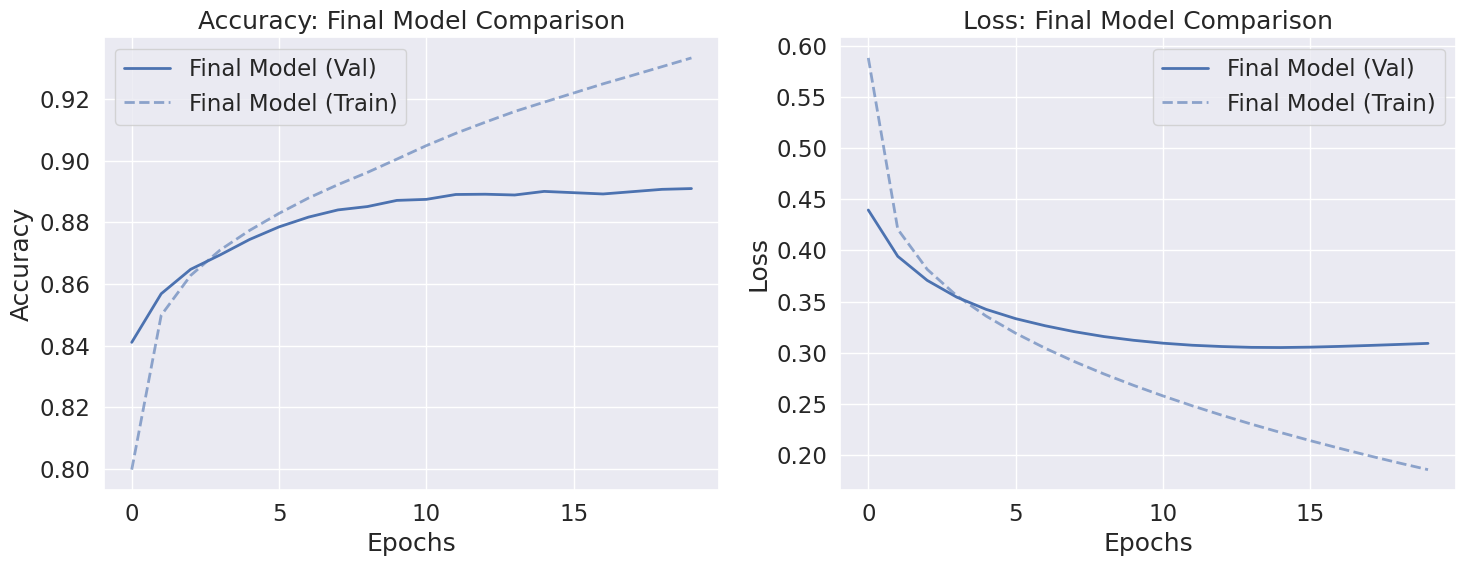

Final Test Loss:     0.3437
Final Test Accuracy: 0.8779
Test Loss:     0.3437
Test Accuracy: 0.8779


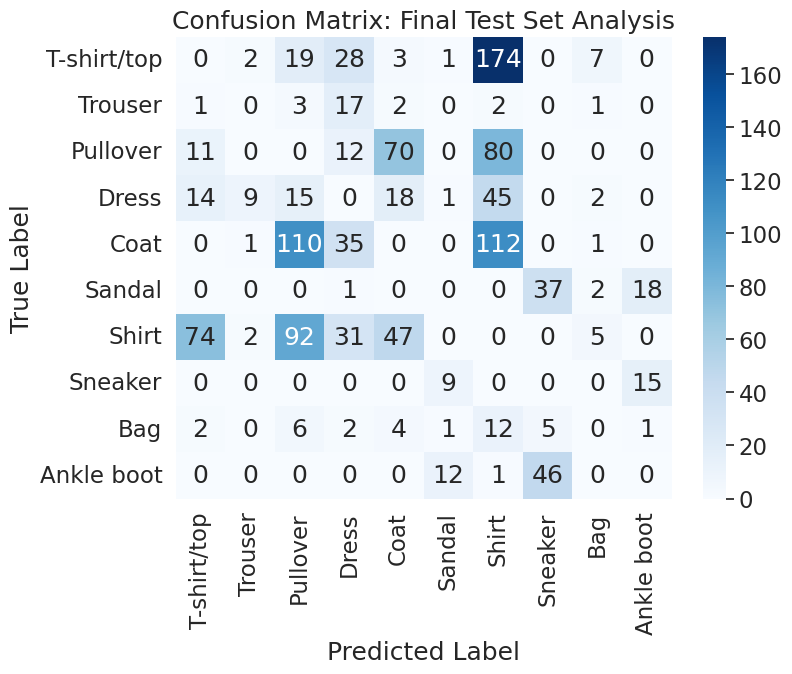

In [17]:
# --- Evaluate the Test Set ---

# Reset memory and randomness
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Build test set model
final_model = build_model(
    hidden_nodes=256,
    activation='sigmoid',
    loss='categorical_crossentropy'
)

# Train the Model
# We still use x_val to monitor overfitting during training, but the final score comes from x_test
history_final = train_model(final_model, x_train, y_train, x_val, y_val)

# Plot history
final_experiment_list = [{
    'name': 'Final Model',
    'history': history_final,
    'model': final_model
}]

plot_experiment_comparison(
    final_experiment_list,
    param_key='name',
    title_label='Final Model'
)

# Evaluate on test set
test_loss, test_acc = final_model.evaluate(x_test, y_test, verbose=0)

print(f"Final Test Loss:     {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
analyze_val(
    final_model,
    x_test,
    y_test,
    label_dict,
    title="Final Test Set Analysis"
)

## Discussion

**1. The Generalization Gap & Overfitting**

The final model achieved a test accuracy of 87.79%, closely matching the validation accuracy (~88%). While this proves the evaluation pipeline is free of data leakage, there is still a persistent gap between the training accuracy and the validation/test metrics. This indicates that the network is still overfitting.

Interestingly, our specific hyperparameter choices heavily influenced how this overfitting occurred:

- **Network Capacity:** Increasing the hidden layer size to 256 nodes produced the highest validation accuracy, but the improvement over 128 nodes was small. However, this small gain required nearly doubling the number of parameters (from ~100k to ~200k), which also increased overfitting. This shows diminishing returns, where adding more neurons marginally improves performance despite doubling complexity. This suggests that FCNN is reaching its structural limit.

- **Activation Function:** During experimentation, the Sigmoid activation model initially showed higher loss and slower learning compared to ReLU. This is because Sigmoid produces smaller gradients, which slows down weight updates during training. While this makes learning less efficient, the slower learning also functioned as an implicit form of regularization, delaying overfitting. As a result, the model achieved strong validation performance later in training.

- **Loss Function:** Categorical Cross Entropy (CCE) is the appropriate loss function for multi-class classification tasks because the model outputs a probability distribution over 10 classes using softmax. Unlike Mean Squared Error (MSE), which treats the problem like regression, CCE directly measures how well the predicted probabilities align with the true class and penalizes confident incorrect predictions more strongly. This leads to faster and more effective learning. However, this strong learning signal can also cause a high-capacity model to fit the training data too closely, which. may have contributed to overfitting in later epochs.



**2. Architectural Limitations**

A FCNN requires flattening the 28x28 image into a 1D vector, which inherently destroys the 2D spatial relationships between pixels. The network has likely hit the performance ceiling for this specific architecture. To break past the ~88% threshold, the architecture must evolve to include Convolutional Neural Networks (CNNs), which preserve spatial hierarchies.

**3. Confusion Matrix Analysis**

The confusion matrix shows that errors are systematic rather than random. The model performs very well on visually distinct classes such as Trouser, Bag, and Ankle Boot, which have clear silhouettes. Most misclassifications occur among similar upper-body garments (Shirt, T-shirt, Pullover, Coat), which look highly alike at 28×28 resolution. This indicates that the FCNN relies mainly on overall shape and pixel intensity patterns, while struggling to capture subtle local features needed to distinguish similar clothing items.